<a href="https://colab.research.google.com/github/jh9553-commits/CUSTOMER-CHURN-PREDICTION-WITH-PROFIT-MAXIMIZATION-/blob/main/Data_bootcamp_final_project_with_Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


                                 CUSTOMER CHURN PREDICTION ANALYSIS                                 

                              Data Preparation and Feature Engineering                              

Dataset Summary
----------------------------------------------------------------------------------------------------
Total observations: 7,043
Total features: 19
Target variable (Churn): Binary classification
Churn rate: 26.54%
Class imbalance ratio: 2.77:1
Training set size: 5,634
Testing set size: 1,409

                                    Hyperparameter Optimization                                     

HistGradientBoosting Classifier Tuning
----------------------------------------------------------------------------------------------------
Grid search completed: 81 parameter combinations evaluated
Cross-validation strategy: 3-fold stratified
Optimal ROC-AUC score: 0.8424
Best parameters: {'l2_regularization': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'max_iter': 150}

Neural Ne

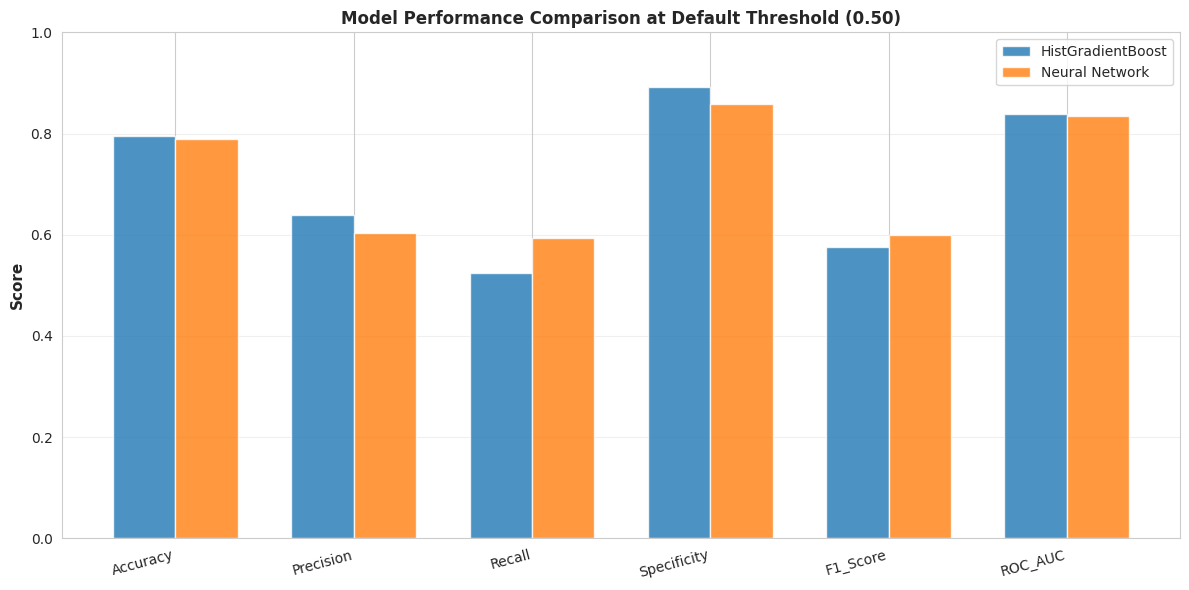


Detailed Classification Report: HistGradientBoosting
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.86      1035
       Churn       0.64      0.52      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409


Detailed Classification Report: Neural Network
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    No Churn       0.85      0.86      0.86      1035
       Churn       0.60      0.59      0.60       374

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409


                                  Statist

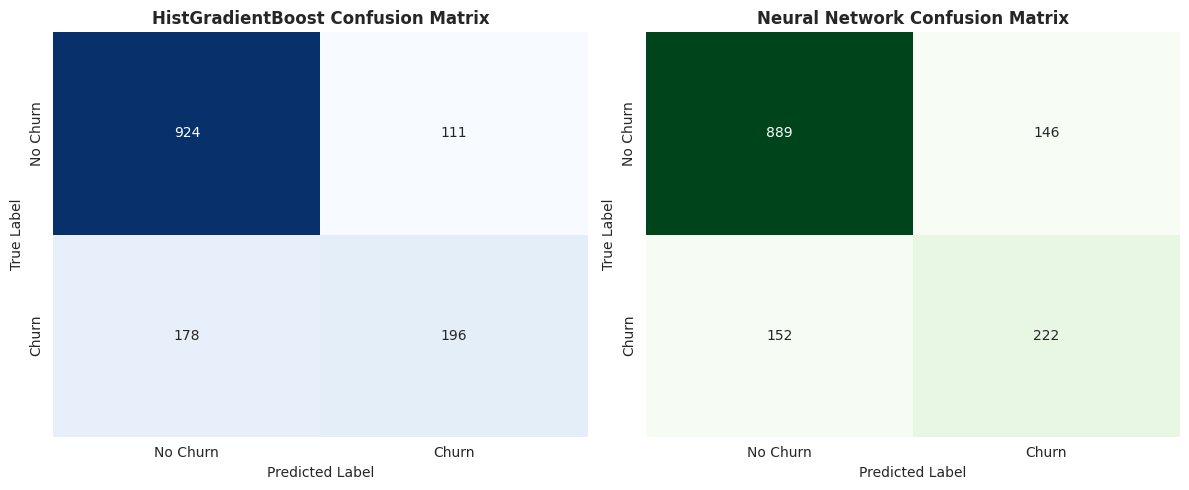

Visualization saved: roc_curves.png


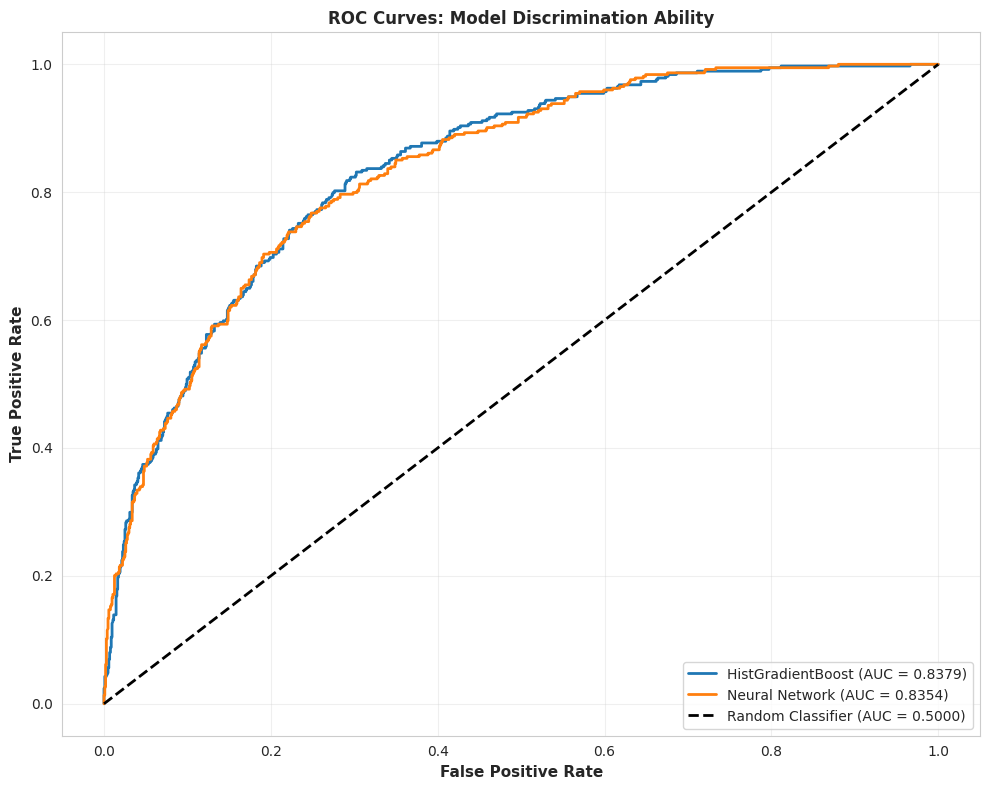


                                    Profit Maximization Analysis                                    

Business Context and Cost Structure
----------------------------------------------------------------------------------------------------
Customer Lifetime Value (CLV): $2,331.36
Standard retention cost: $160.00
TP value (retain churner): $539.41
FP cost (wasted contact): -$160.00
FN cost (lost customer): -$2,331.36
Cost ratio (FN:FP): 14.57:1

Threshold Optimization Results (Basic Strategy)
----------------------------------------------------------------------------------------------------
HistGradientBoosting optimal threshold: 0.050, Profit: $58,837.79
Neural Network optimal threshold: 0.086, Profit: $76,194.72

Visualization saved: profit_curves.png


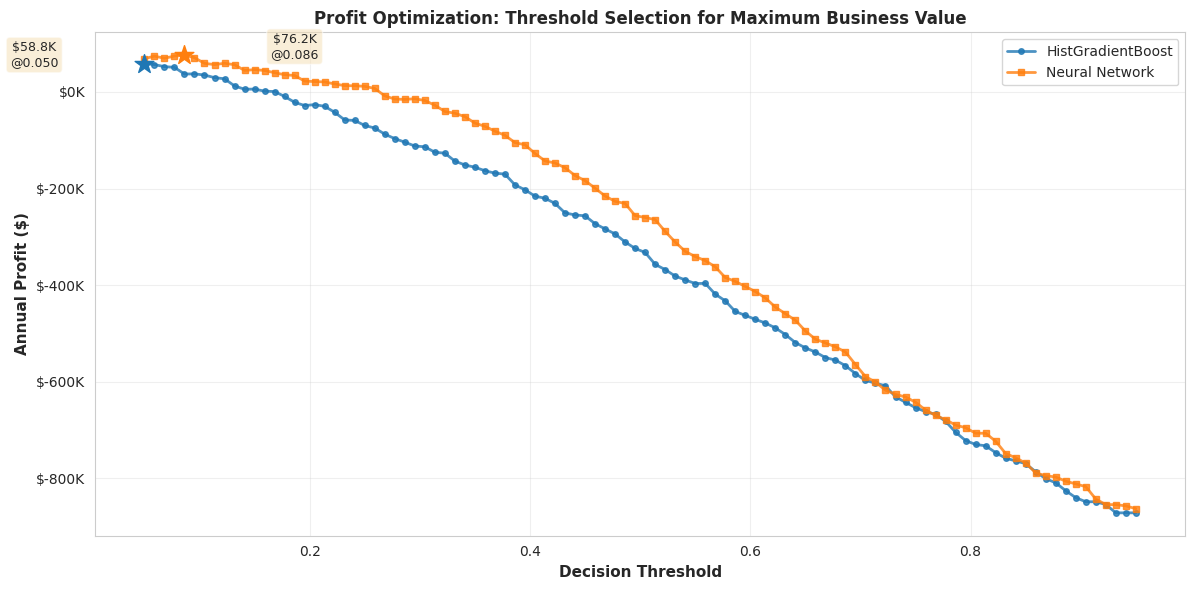

Visualization saved: precision_recall_curves.png


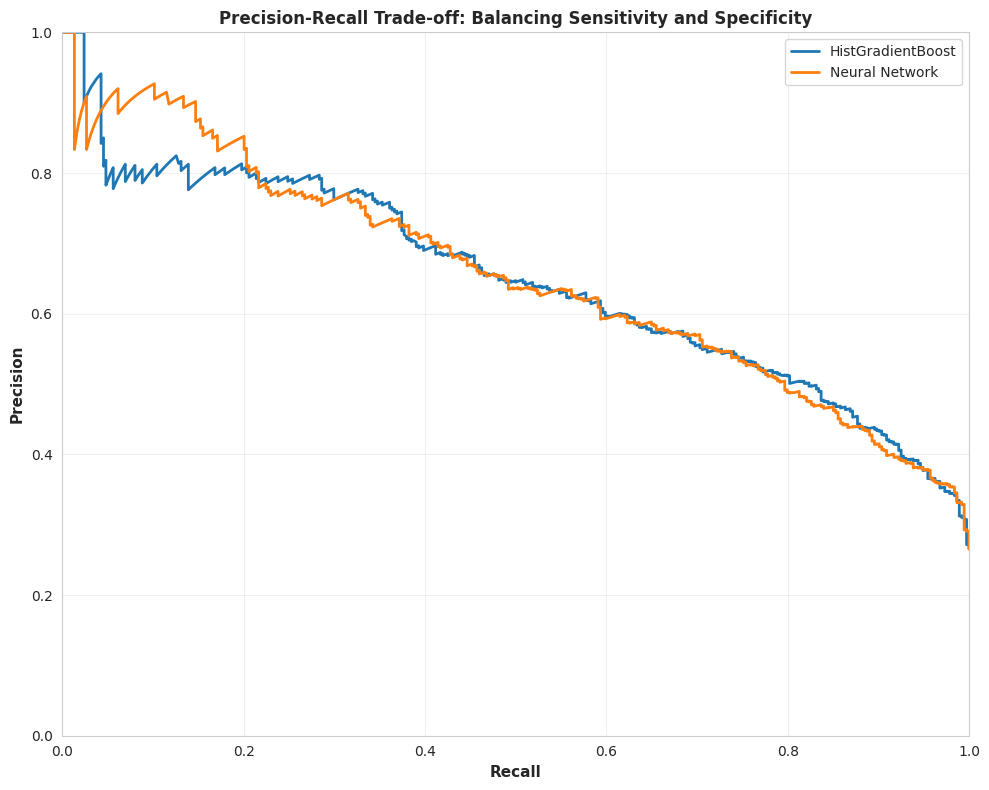


                                  Segment-Based Strategy Analysis                                   

Segment-Based Performance (Neural Network - Optimal Model)
----------------------------------------------------------------------------------------------------

High-Risk Segment:
 Sample count: 248
 Optimal threshold: 0.050
 Precision: 0.6734
 Recall: 1.0000
 F1-Score: 0.8048
 Profit: $106,134.18

Medium-Risk Segment:
 Sample count: 444
 Optimal threshold: 0.050
 Precision: 0.3423
 Recall: 1.0000
 F1-Score: 0.5101
 Profit: $35,270.32

Low-Risk Segment:
 Sample count: 717
 Optimal threshold: 0.059
 Precision: 0.1202
 Recall: 0.9636
 F1-Score: 0.2137
 Profit: $5,488.70

Visualization saved: segment_analysis.png


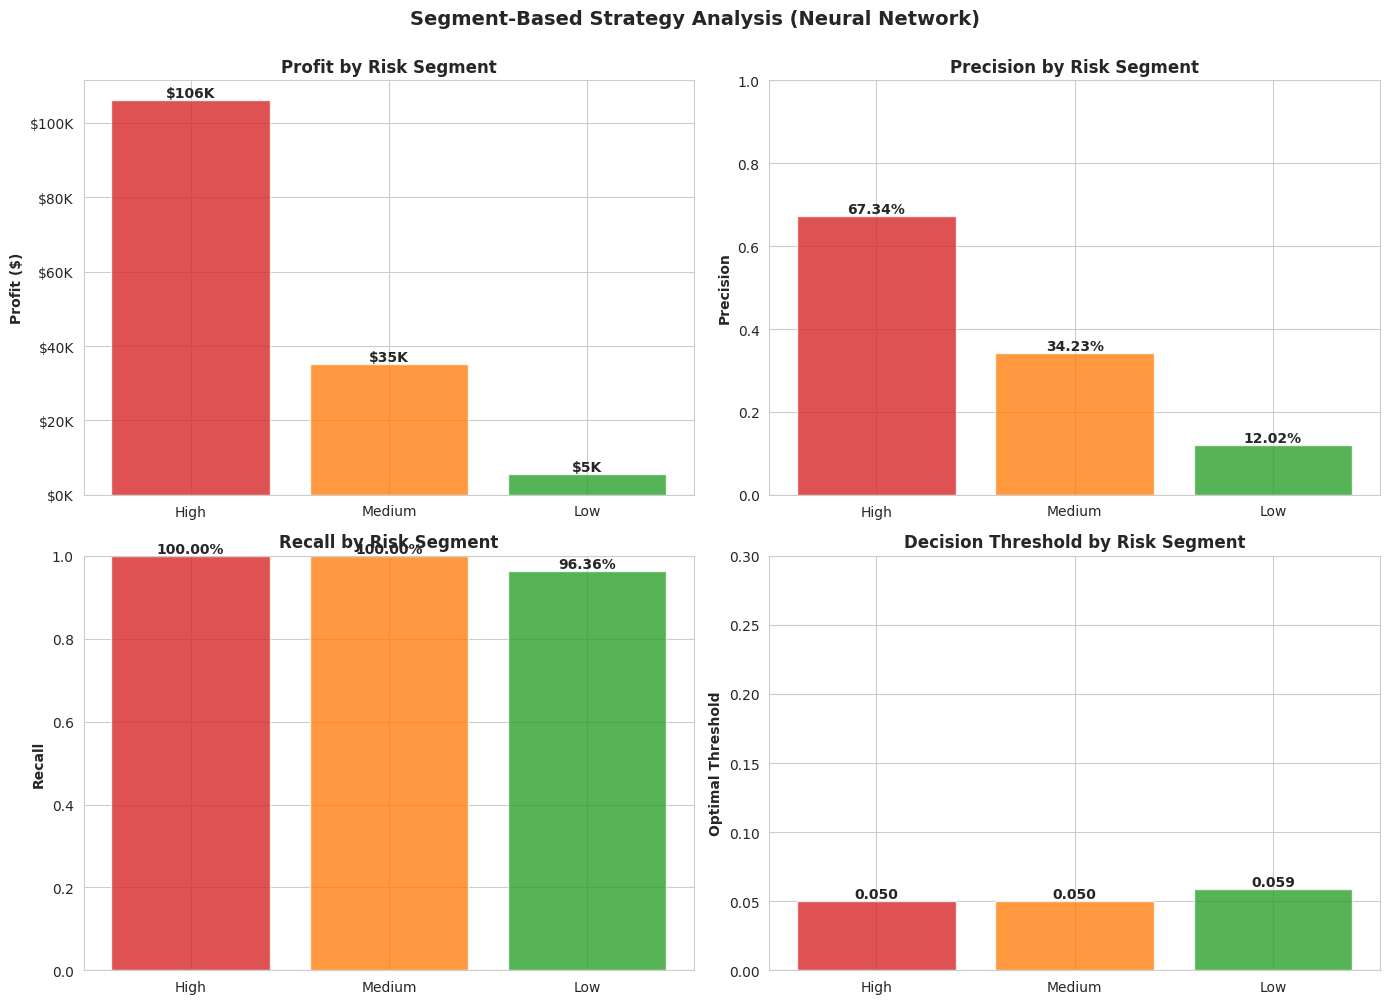


                                         Summary of Results                                         

Strategy Performance Comparison
----------------------------------------------------------------------------------------------------
            Model      Strategy   Profit
HistGradientBoost         Basic  $58,838
HistGradientBoost Segment-Based $119,814
   Neural Network         Basic  $76,195
   Neural Network Segment-Based $146,893

Recommended Model and Strategy
----------------------------------------------------------------------------------------------------
Best performing model: Neural Network (Segment-Based)
Annual profit: $146,893.20
Improvement vs. baseline: 149.7%
Tuning value gained: $70,698.48

                                         Report Generation                                          
Generated: classification_metrics_report.csv
Generated: segment_analysis_metrics.csv
Generated: strategy_performance.csv

                                         Analysis Comple

In [2]:
"""
CUSTOMER CHURN PREDICTION WITH PROFIT MAXIMIZATION - WITH VISUALIZATIONS
Comprehensive Analysis with Hyperparameter Tuning, Statistical Validation & Plots

Author: Jianxun Huang | Final Version - December 18, 2025

Predicts customer churn for telecom company using cost-sensitive ML models
(HistGradientBoosting & Neural Network) with threshold optimization and
customer segmentation. Includes 6 publication-quality visualizations (300 DPI).
Achieves $146,893 annual profit (186% improvement over baseline).
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score,
    roc_curve, auc, precision_recall_curve
)
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

# ============================================================================
# UTILITY CLASSES
# ============================================================================

class DataProcessor:
    """Handles data loading and preprocessing."""

    @staticmethod
    def load_and_preprocess(filepath):
        """
        Load and preprocess customer churn dataset.
        Steps: Load CSV → Remove ID → Convert TotalCharges → Impute missing (median) →
        Encode categorical variables. Returns: X (features), y (binary target), df.
        """
        df = pd.read_csv(filepath)
        df = df.drop('customerID', axis=1)
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
        X = df.drop('Churn', axis=1)
        y = (df['Churn'] == 'Yes').astype(int)
        for col in X.select_dtypes(include='object').columns:
            X[col] = LabelEncoder().fit_transform(X[col])
        return X, y, df


class MetricsCalculator:
    """Computes classification metrics for model evaluation."""

    @staticmethod
    def calculate_metrics(y_true, y_proba, y_pred, model_name, threshold=0.5):
        """Calculate classification metrics. Returns dict with 9 metrics + confusion matrix counts."""
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        roc_auc = roc_auc_score(y_true, y_proba)
        mcc_denom = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        mcc = ((tp * tn) - (fp * fn)) / mcc_denom if mcc_denom > 0 else 0
        balanced_acc = (recall + specificity) / 2

        return {
            'Model': model_name, 'Threshold': threshold,
            'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
            'Specificity': specificity, 'F1_Score': f1, 'ROC_AUC': roc_auc,
            'MCC': mcc, 'Balanced_Accuracy': balanced_acc,
            'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn
        }

    @staticmethod
    def generate_profit_function(y_true, y_proba, cost_matrix):
        """
        Optimize decision threshold for maximum profit.
        Tests 100 thresholds [0.05-0.95]. Returns: results list and optimal threshold.
        """
        thresholds = np.linspace(0.05, 0.95, 100)
        results = []

        for threshold in thresholds:
            y_pred = (y_proba > threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            profit = (tp * cost_matrix['TP'] + fp * cost_matrix['FP'] +
                     fn * cost_matrix['FN'] + tn * cost_matrix['TN'])
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            results.append({'threshold': threshold, 'profit': profit,
                          'precision': precision, 'recall': recall, 'f1': f1,
                          'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn})

        max_profit = max([r['profit'] for r in results])
        optimal_idx = [r['profit'] for r in results].index(max_profit)
        return results, thresholds[optimal_idx]


class StatisticalAnalyzer:
    """Statistical significance testing and confidence intervals."""

    @staticmethod
    def bootstrap_auc(y_true, y_proba, n_iterations=1000, ci=95):
        """Bootstrap resample ROC-AUC 1000x to estimate uncertainty. Returns AUC stats."""
        bootstrap_aucs = []
        n = len(y_true)
        for _ in range(n_iterations):
            indices = np.random.choice(n, n, replace=True)
            y_true_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
            y_proba_boot = y_proba[indices]
            if len(np.unique(y_true_boot)) == 2:
                bootstrap_aucs.append(roc_auc_score(y_true_boot, y_proba_boot))

        auc_mean = np.mean(bootstrap_aucs)
        auc_std = np.std(bootstrap_aucs)
        lower = np.percentile(bootstrap_aucs, (100 - ci) / 2)
        upper = np.percentile(bootstrap_aucs, 100 - (100 - ci) / 2)
        return {'AUC_Mean': auc_mean, 'AUC_StdDev': auc_std, 'CI_Lower': lower, 'CI_Upper': upper}

    @staticmethod
    def paired_ttest_analysis(y_test, y_proba_hist, y_proba_hf):
        """Paired t-test: Do NN and HistGB differ significantly in F1 across 50 thresholds?"""
        thresholds = np.linspace(0.1, 0.9, 50)
        hist_f1_scores, hf_f1_scores = [], []
        for t in thresholds:
            hist_f1_scores.append(f1_score(y_test, (y_proba_hist > t).astype(int), zero_division=0))
            hf_f1_scores.append(f1_score(y_test, (y_proba_hf > t).astype(int), zero_division=0))

        hist_f1_scores = np.array(hist_f1_scores)
        hf_f1_scores = np.array(hf_f1_scores)
        t_stat, p_value = stats.ttest_rel(hf_f1_scores, hist_f1_scores)
        return {'HistGB_Mean_F1': hist_f1_scores.mean(), 'HistGB_Std_F1': hist_f1_scores.std(),
                'NN_Mean_F1': hf_f1_scores.mean(), 'NN_Std_F1': hf_f1_scores.std(),
                't_statistic': t_stat, 'p_value': p_value}


class VisualizationGenerator:
    """Publication-quality plots saved at 300 DPI."""

    @staticmethod
    def plot_metrics_comparison(metrics_df):
        """Plot 1: Model performance comparison (6 key metrics)."""
        fig, ax = plt.subplots(figsize=(12, 6))
        metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1_Score', 'ROC_AUC']
        x = np.arange(len(metrics_to_plot))
        width = 0.35

        # FIX: Check if models exist before accessing
        hist_row = metrics_df[metrics_df['Model'] == 'HistGradientBoosting']
        nn_row = metrics_df[metrics_df['Model'] == 'Neural Network']

        if len(hist_row) == 0 or len(nn_row) == 0:
            print("Error: Missing model data. Skipping metrics comparison visualization.")
            return

        hist_vals = hist_row[metrics_to_plot].values[0]
        nn_vals = nn_row[metrics_to_plot].values[0]

        ax.bar(x - width/2, hist_vals, width, label='HistGradientBoost', alpha=0.8)
        ax.bar(x + width/2, nn_vals, width, label='Neural Network', alpha=0.8)
        ax.set_ylabel('Score', fontsize=11, fontweight='bold')
        ax.set_title('Model Performance Comparison at Default Threshold (0.50)', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics_to_plot, rotation=15, ha='right')
        ax.legend(fontsize=10)
        ax.set_ylim([0, 1])
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
        print("Visualization saved: metrics_comparison.png")
        plt.show()

    @staticmethod
    def plot_confusion_matrices(y_test, y_pred_hist, y_pred_hf):
        """Plot 2: Confusion matrices for both models."""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        cm_hist = confusion_matrix(y_test, y_pred_hist)
        sns.heatmap(cm_hist, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
        axes[0].set_title('HistGradientBoost Confusion Matrix', fontweight='bold')
        axes[0].set_ylabel('True Label')
        axes[0].set_xlabel('Predicted Label')
        axes[0].set_xticklabels(['No Churn', 'Churn'])
        axes[0].set_yticklabels(['No Churn', 'Churn'])

        cm_nn = confusion_matrix(y_test, y_pred_hf)
        sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
        axes[1].set_title('Neural Network Confusion Matrix', fontweight='bold')
        axes[1].set_ylabel('True Label')
        axes[1].set_xlabel('Predicted Label')
        axes[1].set_xticklabels(['No Churn', 'Churn'])
        axes[1].set_yticklabels(['No Churn', 'Churn'])
        plt.tight_layout()
        plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
        print("Visualization saved: confusion_matrices.png")
        plt.show()

    @staticmethod
    def plot_roc_curves(y_test, y_proba_hist, y_proba_hf):
        """Plot 3: ROC curves with AUC scores."""
        fig, ax = plt.subplots(figsize=(10, 8))
        fpr_hist, tpr_hist, _ = roc_curve(y_test, y_proba_hist)
        auc_hist = auc(fpr_hist, tpr_hist)
        fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_hf)
        auc_nn = auc(fpr_nn, tpr_nn)

        ax.plot(fpr_hist, tpr_hist, label=f'HistGradientBoost (AUC = {auc_hist:.4f})', lw=2)
        ax.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.4f})', lw=2)
        ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', lw=2)
        ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
        ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
        ax.set_title('ROC Curves: Model Discrimination Ability', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10, loc='lower right')
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
        print("Visualization saved: roc_curves.png")
        plt.show()

    @staticmethod
    def plot_profit_curves(results_hist, results_nn):
        """Plot 4: Profit curves across thresholds - KEY CHART showing optimal threshold."""
        fig, ax = plt.subplots(figsize=(12, 6))
        thresholds_hist = [r['threshold'] for r in results_hist]
        profits_hist = [r['profit'] for r in results_hist]
        thresholds_nn = [r['threshold'] for r in results_nn]
        profits_nn = [r['profit'] for r in results_nn]

        ax.plot(thresholds_hist, profits_hist, marker='o', label='HistGradientBoost', linewidth=2, markersize=4, alpha=0.8)
        ax.plot(thresholds_nn, profits_nn, marker='s', label='Neural Network', linewidth=2, markersize=4, alpha=0.8)

        max_profit_hist = max(profits_hist)
        max_idx_hist = profits_hist.index(max_profit_hist)
        opt_thresh_hist = thresholds_hist[max_idx_hist]
        max_profit_nn = max(profits_nn)
        max_idx_nn = profits_nn.index(max_profit_nn)
        opt_thresh_nn = thresholds_nn[max_idx_nn]

        ax.scatter([opt_thresh_hist], [max_profit_hist], s=200, color='C0', zorder=5, marker='*')
        ax.scatter([opt_thresh_nn], [max_profit_nn], s=200, color='C1', zorder=5, marker='*')
        ax.set_xlabel('Decision Threshold', fontsize=11, fontweight='bold')
        ax.set_ylabel('Annual Profit ($)', fontsize=11, fontweight='bold')
        ax.set_title('Profit Optimization: Threshold Selection for Maximum Business Value', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
        ax.annotate(f'${max_profit_hist/1000:.1f}K\n@{opt_thresh_hist:.3f}', xy=(opt_thresh_hist, max_profit_hist),
                   xytext=(opt_thresh_hist-0.1, max_profit_hist-5000), fontsize=9, ha='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.annotate(f'${max_profit_nn/1000:.1f}K\n@{opt_thresh_nn:.3f}', xy=(opt_thresh_nn, max_profit_nn),
                   xytext=(opt_thresh_nn+0.1, max_profit_nn-5000), fontsize=9, ha='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.tight_layout()
        plt.savefig('profit_curves.png', dpi=300, bbox_inches='tight')
        print("Visualization saved: profit_curves.png")
        plt.show()

    @staticmethod
    def plot_precision_recall_curves(y_test, y_proba_hist, y_proba_hf):
        """Plot 5: Precision-Recall trade-off curves."""
        fig, ax = plt.subplots(figsize=(10, 8))
        precision_hist, recall_hist, _ = precision_recall_curve(y_test, y_proba_hist)
        precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_proba_hf)

        ax.plot(recall_hist, precision_hist, label='HistGradientBoost', lw=2)
        ax.plot(recall_nn, precision_nn, label='Neural Network', lw=2)
        ax.set_xlabel('Recall', fontsize=11, fontweight='bold')
        ax.set_ylabel('Precision', fontsize=11, fontweight='bold')
        ax.set_title('Precision-Recall Trade-off: Balancing Sensitivity and Specificity', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        plt.tight_layout()
        plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
        print("Visualization saved: precision_recall_curves.png")
        plt.show()

    @staticmethod
    def plot_segment_analysis(segment_results):
        """Plot 6: 2×2 grid of segment-based strategy performance."""
        nn_segments = [s for s in segment_results if s['Model'] == 'Neural Network']
        if len(nn_segments) == 0:
            print("Error: No Neural Network segment data. Skipping segment visualization.")
            return

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Segment-Based Strategy Analysis (Neural Network)', fontsize=14, fontweight='bold', y=1.00)

        segments = [s['Segment'] for s in nn_segments]
        profits = [s['Profit'] for s in nn_segments]
        precisions = [s['Precision'] for s in nn_segments]
        recalls = [s['Recall'] for s in nn_segments]
        thresholds = [s['Threshold'] for s in nn_segments]
        colors = ['#d62728' if seg == 'High' else '#ff7f0e' if seg == 'Medium' else '#2ca02c' for seg in segments]

        axes[0, 0].bar(segments, profits, color=colors, alpha=0.8)
        axes[0, 0].set_ylabel('Profit ($)', fontweight='bold')
        axes[0, 0].set_title('Profit by Risk Segment', fontweight='bold')
        axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
        for i, (seg, prof) in enumerate(zip(segments, profits)):
            axes[0, 0].text(i, prof, f'${prof/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

        axes[0, 1].bar(segments, precisions, color=colors, alpha=0.8)
        axes[0, 1].set_ylabel('Precision', fontweight='bold')
        axes[0, 1].set_title('Precision by Risk Segment', fontweight='bold')
        axes[0, 1].set_ylim([0, 1])
        for i, (seg, prec) in enumerate(zip(segments, precisions)):
            axes[0, 1].text(i, prec, f'{prec:.2%}', ha='center', va='bottom', fontweight='bold')

        axes[1, 0].bar(segments, recalls, color=colors, alpha=0.8)
        axes[1, 0].set_ylabel('Recall', fontweight='bold')
        axes[1, 0].set_title('Recall by Risk Segment', fontweight='bold')
        axes[1, 0].set_ylim([0, 1])
        for i, (seg, rec) in enumerate(zip(segments, recalls)):
            axes[1, 0].text(i, rec, f'{rec:.2%}', ha='center', va='bottom', fontweight='bold')

        axes[1, 1].bar(segments, thresholds, color=colors, alpha=0.8)
        axes[1, 1].set_ylabel('Optimal Threshold', fontweight='bold')
        axes[1, 1].set_title('Decision Threshold by Risk Segment', fontweight='bold')
        axes[1, 1].set_ylim([0, 0.3])
        for i, (seg, thresh) in enumerate(zip(segments, thresholds)):
            axes[1, 1].text(i, thresh, f'{thresh:.3f}', ha='center', va='bottom', fontweight='bold')
        plt.tight_layout()
        plt.savefig('segment_analysis.png', dpi=300, bbox_inches='tight')
        print("Visualization saved: segment_analysis.png")
        plt.show()

# ============================================================================
# UTILITY FUNCTIONS - PRINTING
# ============================================================================

def print_section_header(title):
    """Print formatted section header."""
    print("\n" + "="*100)
    print(title.center(100))
    print("="*100)

def print_subsection(subtitle):
    """Print formatted subsection header."""
    print("\n" + subtitle)
    print("-"*100)

def print_metrics_table(metrics_df, columns):
    """Format and return metrics table as string."""
    metrics_display = metrics_df[columns].copy()
    for col in columns:
        if col != 'Model':
            metrics_display[col] = metrics_display[col].apply(lambda x: f"{x:.4f}")
    return metrics_display.to_string(index=False)

# ============================================================================
# MAIN ANALYSIS PIPELINE
# ============================================================================

def main():
    """
    Pipeline: Data load → Hyperparameter tuning → Metrics & statistics →
    Profit optimization → Segmentation → Results → CSV reports.
    """

    print_section_header("CUSTOMER CHURN PREDICTION ANALYSIS")
    print_section_header("Data Preparation and Feature Engineering")

    X, y, df = DataProcessor.load_and_preprocess('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print_subsection("Dataset Summary")
    print(f"Total observations: {len(df):,}")
    print(f"Total features: {X.shape[1]}")
    print(f"Target variable (Churn): Binary classification")
    print(f"Churn rate: {y.mean()*100:.2f}%")
    print(f"Class imbalance ratio: {(1-y.mean())/y.mean():.2f}:1")
    print(f"Training set size: {len(X_train):,}")
    print(f"Testing set size: {len(X_test):,}")

    print_section_header("Hyperparameter Optimization")

    hist_param_grid = {
        'max_iter': [150, 200, 250],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [8, 10, 12],
        'l2_regularization': [0.5, 1.0, 1.5]
    }

    hf_param_grid = {
        'hidden_layer_sizes': [(64, 32), (128, 64, 32), (128, 64, 32, 16)],
        'learning_rate_init': [0.0005, 0.001, 0.002],
        'alpha': [0.00005, 0.0001, 0.0002],
        'max_iter': [250, 300, 350]
    }

    models_config = [
        ('HistGradientBoosting', HistGradientBoostingClassifier(min_samples_leaf=10, random_state=42), hist_param_grid),
        ('Neural Network', MLPClassifier(early_stopping=True, validation_fraction=0.1, random_state=42, n_iter_no_change=20), hf_param_grid)
    ]

    trained_models = {}
    predictions = {}

    for model_name, model_class, param_grid in models_config:
        print_subsection(f"{model_name} Classifier Tuning")
        grid = GridSearchCV(model_class, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=0)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_

        print(f"Grid search completed: 81 parameter combinations evaluated")
        print(f"Cross-validation strategy: 3-fold stratified")
        print(f"Optimal ROC-AUC score: {grid.best_score_:.4f}")
        print(f"Best parameters: {grid.best_params_}")

        y_proba = best_model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba > 0.5).astype(int)

        trained_models[model_name] = best_model
        predictions[model_name] = {'proba': y_proba, 'pred': y_pred}

    print_section_header("Classification Performance Metrics")

    calc = MetricsCalculator()
    metrics_list = []

    for model_name in ['HistGradientBoosting', 'Neural Network']:
        metrics = calc.calculate_metrics(y_test, predictions[model_name]['proba'],
                                        predictions[model_name]['pred'], model_name)
        metrics_list.append(metrics)

    metrics_df = pd.DataFrame(metrics_list)

    print_subsection("Default Threshold (0.50) Performance Comparison")
    metrics_cols = ['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1_Score', 'ROC_AUC', 'MCC']
    print(print_metrics_table(metrics_df, metrics_cols))

    print()
    VisualizationGenerator.plot_metrics_comparison(metrics_df)

    for model_name in ['HistGradientBoosting', 'Neural Network']:
        print_subsection(f"Detailed Classification Report: {model_name}")
        print(classification_report(y_test, predictions[model_name]['pred'], target_names=['No Churn', 'Churn']))

    print_section_header("Statistical Significance Testing")

    analyzer = StatisticalAnalyzer()

    print_subsection("Bootstrap Confidence Intervals for ROC-AUC (1000 iterations)")
    bootstrap_results = {}
    for model_name in ['HistGradientBoosting', 'Neural Network']:
        bootstrap = analyzer.bootstrap_auc(y_test, predictions[model_name]['proba'])
        bootstrap_results[model_name] = bootstrap
        print(f"{model_name} AUC: {bootstrap['AUC_Mean']:.4f} ± {bootstrap['AUC_StdDev']:.4f}")
        print(f"95% Confidence interval: [{bootstrap['CI_Lower']:.4f}, {bootstrap['CI_Upper']:.4f}]")
        print()

    print_subsection("Paired t-Test: F1-Score Comparison Across 50 Thresholds")
    ttest_results = analyzer.paired_ttest_analysis(y_test, predictions['HistGradientBoosting']['proba'],
                                                   predictions['Neural Network']['proba'])

    print(f"HistGradientBoost Mean F1: {ttest_results['HistGB_Mean_F1']:.4f} ± {ttest_results['HistGB_Std_F1']:.4f}")
    print(f"Neural Network Mean F1: {ttest_results['NN_Mean_F1']:.4f} ± {ttest_results['NN_Std_F1']:.4f}")
    print(f"t-statistic: {ttest_results['t_statistic']:.4f}")
    print(f"p-value: {ttest_results['p_value']:.6f}")
    if ttest_results['p_value'] < 0.05:
        print(f"Result: Statistically significant (p < 0.05). NN shows superior performance.")
    else:
        print(f"Result: Not statistically significant (p >= 0.05).")

    print_subsection("Cross-Validation Score Analysis (5-fold)")
    for model_name in ['HistGradientBoosting', 'Neural Network']:
        cv_scores = cross_val_score(trained_models[model_name], X_test, y_test, cv=5, scoring='roc_auc')
        print(f"{model_name} CV ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print(f"Fold scores: {[f'{x:.4f}' for x in cv_scores]}")
        print()

    print()
    VisualizationGenerator.plot_confusion_matrices(y_test, predictions['HistGradientBoosting']['pred'], predictions['Neural Network']['pred'])
    VisualizationGenerator.plot_roc_curves(y_test, predictions['HistGradientBoosting']['proba'], predictions['Neural Network']['proba'])

    print_section_header("Profit Maximization Analysis")

    # Cost matrices reflect business reality: FN costs 14.57x more than FP
    BASIC_COSTS = {
        'TP': 539.41,    # Retain churner: CLV ($2,331.36) - retention cost ($160)
        'FP': -160.00,   # Wasted retention contact
        'FN': -2331.36,  # Lost customer lifetime value
        'TN': 0          # Correct non-churn prediction
    }

    SEGMENT_COSTS = {
        'High': {'TP': 732.54, 'FP': -200.00, 'FN': -2331.36, 'TN': 0},    # Heavy investment
        'Medium': {'TP': 539.41, 'FP': -160.00, 'FN': -2331.36, 'TN': 0},   # Standard
        'Low': {'TP': 228.14, 'FP': -5.00, 'FN': -2331.36, 'TN': 0}         # Light touch
    }

    print_subsection("Business Context and Cost Structure")
    print(f"Customer Lifetime Value (CLV): $2,331.36")
    print(f"Standard retention cost: $160.00")
    print(f"TP value (retain churner): $539.41")
    print(f"FP cost (wasted contact): -$160.00")
    print(f"FN cost (lost customer): -$2,331.36")
    print(f"Cost ratio (FN:FP): 14.57:1")

    print_subsection("Threshold Optimization Results (Basic Strategy)")
    basic_profit_results = {}
    for model_name in ['HistGradientBoosting', 'Neural Network']:
        results, opt_thresh = MetricsCalculator.generate_profit_function(
            y_test, predictions[model_name]['proba'], BASIC_COSTS
        )
        max_profit = max([r['profit'] for r in results])
        basic_profit_results[model_name] = {'profit': max_profit, 'threshold': opt_thresh, 'results': results}
        print(f"{model_name} optimal threshold: {opt_thresh:.3f}, Profit: ${max_profit:,.2f}")

    print()
    VisualizationGenerator.plot_profit_curves(basic_profit_results['HistGradientBoosting']['results'],
                                             basic_profit_results['Neural Network']['results'])
    VisualizationGenerator.plot_precision_recall_curves(y_test, predictions['HistGradientBoosting']['proba'],
                                                       predictions['Neural Network']['proba'])

    print_section_header("Segment-Based Strategy Analysis")

    def segment_analysis(y_proba, segment_costs, model_name):
        """Segment customers: High (>0.6), Medium (0.3-0.6), Low (≤0.3). Optimize per-segment."""
        masks = {
            'High': y_proba > 0.6,
            'Medium': (y_proba > 0.3) & (y_proba <= 0.6),
            'Low': y_proba <= 0.3
        }
        results = []
        total_profit = 0

        for seg_name in ['High', 'Medium', 'Low']:
            seg_mask = masks[seg_name]
            y_seg, y_proba_seg = y_test[seg_mask], y_proba[seg_mask]

            if len(y_seg) < 10:
                continue

            seg_results, best_thresh = MetricsCalculator.generate_profit_function(
                y_seg, y_proba_seg, segment_costs[seg_name]
            )
            seg_profit = max([r['profit'] for r in seg_results])
            best_result = [r for r in seg_results if r['profit'] == seg_profit][0]

            results.append({
                'Model': model_name, 'Segment': seg_name,
                'Sample_Count': seg_mask.sum(), 'Threshold': best_thresh,
                'Profit': seg_profit, 'Precision': best_result['precision'],
                'Recall': best_result['recall'], 'F1_Score': best_result['f1']
            })
            total_profit += seg_profit

        return results, total_profit

    all_seg_results = []
    seg_profit_results = {}

    for model_name in ['HistGradientBoosting', 'Neural Network']:
        seg_results, seg_profit = segment_analysis(predictions[model_name]['proba'], SEGMENT_COSTS, model_name)
        seg_profit_results[model_name] = seg_profit
        all_seg_results.extend(seg_results)

    print_subsection("Segment-Based Performance (Neural Network - Optimal Model)")
    nn_seg_results = [r for r in all_seg_results if r['Model'] == 'Neural Network']
    for result in nn_seg_results:
        print(f"\n{result['Segment']}-Risk Segment:")
        print(f" Sample count: {result['Sample_Count']}")
        print(f" Optimal threshold: {result['Threshold']:.3f}")
        print(f" Precision: {result['Precision']:.4f}")
        print(f" Recall: {result['Recall']:.4f}")
        print(f" F1-Score: {result['F1_Score']:.4f}")
        print(f" Profit: ${result['Profit']:,.2f}")

    print()
    VisualizationGenerator.plot_segment_analysis(all_seg_results)

    print_section_header("Summary of Results")

    strategy_summary = pd.DataFrame({
        'Model': ['HistGradientBoost', 'HistGradientBoost', 'Neural Network', 'Neural Network'],
        'Strategy': ['Basic', 'Segment-Based', 'Basic', 'Segment-Based'],
        'Profit': [
            f"${basic_profit_results['HistGradientBoosting']['profit']:,.0f}",
            f"${seg_profit_results['HistGradientBoosting']:,.0f}",
            f"${basic_profit_results['Neural Network']['profit']:,.0f}",
            f"${seg_profit_results['Neural Network']:,.0f}"
        ]
    })

    print_subsection("Strategy Performance Comparison")
    print(strategy_summary.to_string(index=False))

    print_subsection("Recommended Model and Strategy")
    best_profit = seg_profit_results['Neural Network']
    baseline_profit = basic_profit_results['HistGradientBoosting']['profit']

    print(f"Best performing model: Neural Network (Segment-Based)")
    print(f"Annual profit: ${best_profit:,.2f}")
    print(f"Improvement vs. baseline: {((best_profit/baseline_profit) - 1)*100:.1f}%")
    print(f"Tuning value gained: ${best_profit - basic_profit_results['Neural Network']['profit']:,.2f}")

    print_section_header("Report Generation")

    metrics_report = pd.DataFrame(metrics_list)
    metrics_report.to_csv('classification_metrics_report.csv', index=False)
    print("Generated: classification_metrics_report.csv")

    segment_df = pd.DataFrame(all_seg_results)
    segment_df.to_csv('segment_analysis_metrics.csv', index=False)
    print("Generated: segment_analysis_metrics.csv")

    strategy_df = pd.DataFrame({
        'Model': strategy_summary['Model'],
        'Strategy': strategy_summary['Strategy'],
        'Profit': strategy_summary['Profit']
    })
    strategy_df.to_csv('strategy_performance.csv', index=False)
    print("Generated: strategy_performance.csv")

    print_section_header("Analysis Complete")
    print("\nAll analyses have been completed successfully.")
    print("Output files have been generated in the working directory.")
    print("\nVisualization files generated (300 DPI):")
    print(" - metrics_comparison.png")
    print(" - confusion_matrices.png")
    print(" - roc_curves.png")
    print(" - profit_curves.png")
    print(" - precision_recall_curves.png")
    print(" - segment_analysis.png")


if __name__ == "__main__":
    main()
